In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import plotly.express as px
import seaborn as sns
import pytz
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

In [3]:
import datetime as dt
import yfinance as yf

company = 'NFLX'

# Define a start date and End Date
start = dt.datetime(2020,1,1)
end =  dt.datetime(2022,1,1)

# Read Stock Price Data 
data = yf.download(company, start , end)

df = pd.DataFrame(data["Close"])                     
print(df.shape)
df.head()

[*********************100%%**********************]  1 of 1 completed

(505, 1)


,Close
Date,
2020-01-02,329.809998
2020-01-03,325.899994
2020-01-06,335.829987
2020-01-07,330.750000
2020-01-08,339.260010


C:\Users\Luan Lima\AppData\Local\Temp\ipykernel_35344\3648407586.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["Close"], kde = True, color = 'blue', bins = 30, ax = ax)


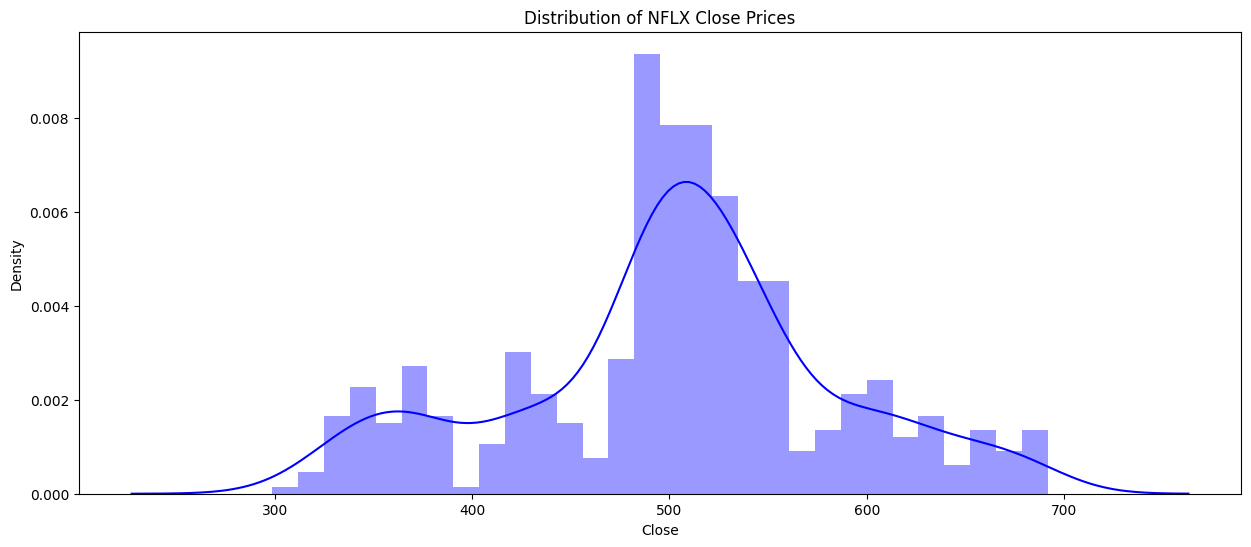

In [4]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.distplot(df["Close"], kde = True, color = 'blue', bins = 30, ax = ax)
ax.set_title("Distribution of NFLX Close Prices");

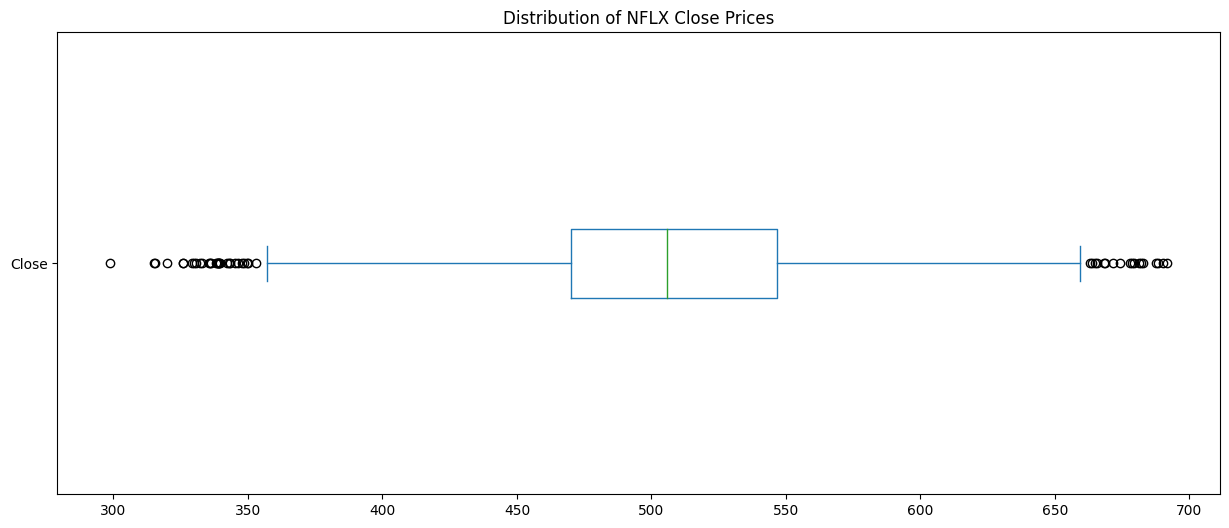

In [5]:
fig, ax = plt.subplots(figsize=(15, 6))
df["Close"].plot(kind="box", vert=False, title="Distribution of NFLX Close Prices",ax=ax);

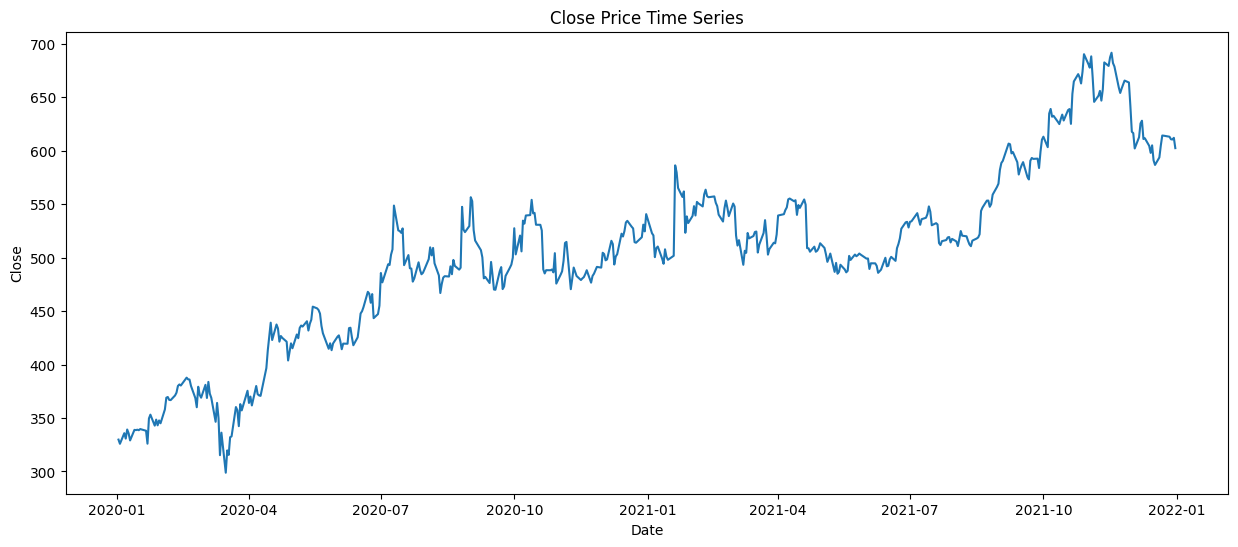

In [6]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = df.index, y = df['Close'], data = df, ax=ax)
ax.set_title("Close Price Time Series");

In [7]:
df= df["Close"]. resample("1D").mean().fillna(method="ffill").to_frame()
df.head()

,Close
Date,
2020-01-02,329.809998
2020-01-03,325.899994
2020-01-04,325.899994
2020-01-05,325.899994
2020-01-06,335.829987


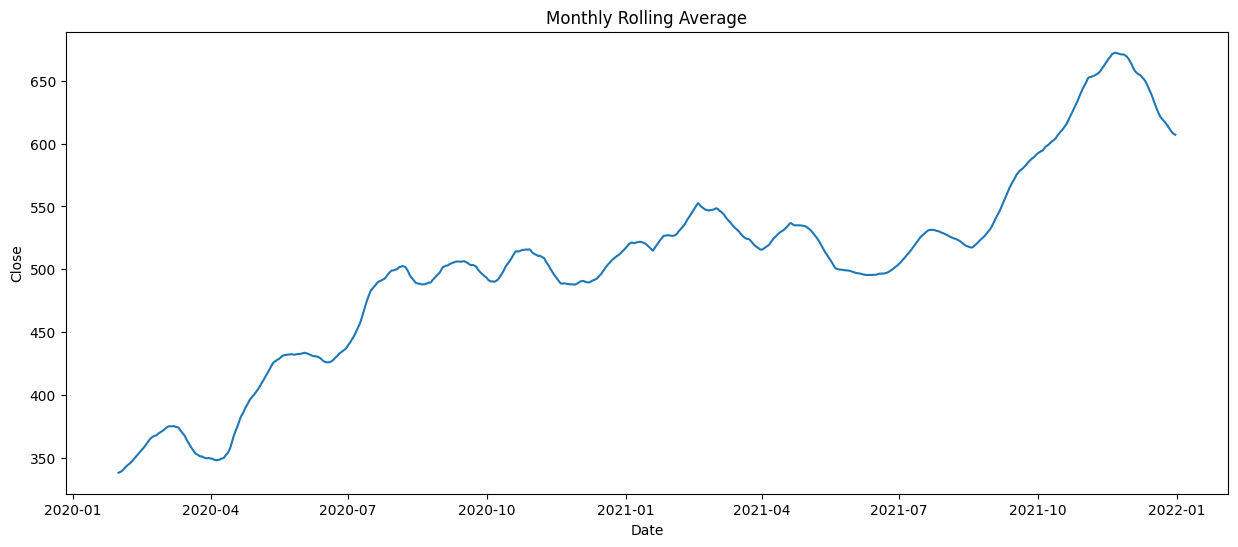

In [8]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = df.index, y = df["Close"].rolling(30).mean(), data = df, ax=ax)
ax.set_title("Monthly Rolling Average");

In [9]:
df["Close.L1"] = df["Close"].shift(1)
df.dropna(inplace = True)
df.head()

,Close,Close.L1
Date,,
2020-01-03,325.899994,329.809998
2020-01-04,325.899994,325.899994
2020-01-05,325.899994,325.899994
2020-01-06,335.829987,325.899994
2020-01-07,330.750000,335.829987


In [10]:
df.corr()

,Close,Close.L1
Close,1.000000,0.992847
Close.L1,0.992847,1.000000


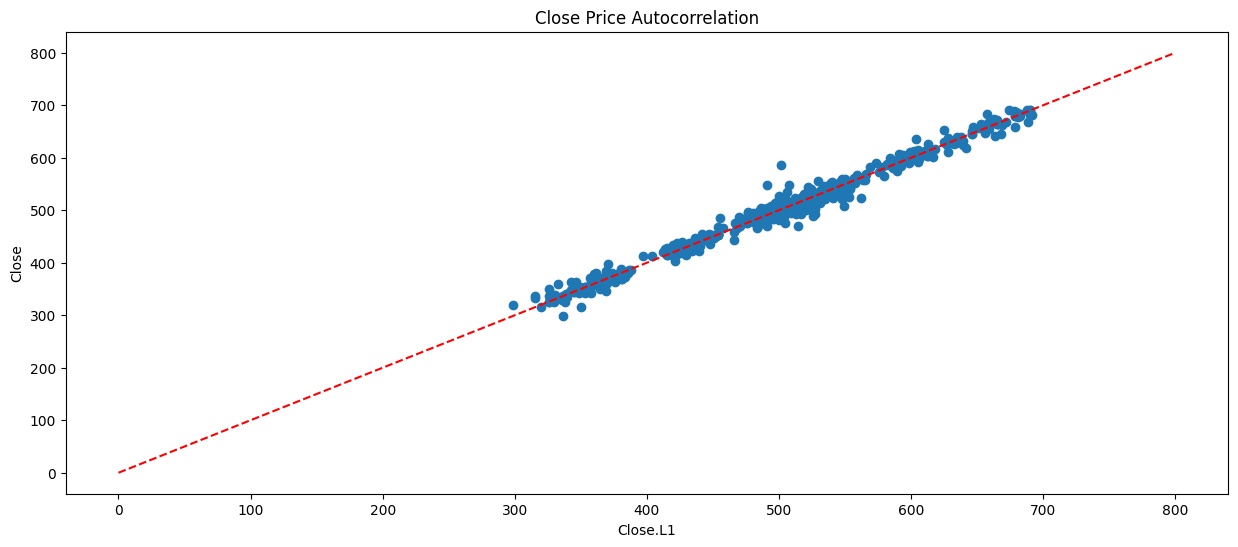

In [11]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(x=df["Close.L1"], y=df["Close"])
ax.plot([0,800],[0,800],linestyle="--", color="red")
plt.xlabel("Close.L1")
plt.ylabel("Close")
plt.title("Close Price Autocorrelation");

In [12]:
# Split the data into featuer and target
target = "Close"
y = df[target]
X = df.drop(columns= target)                                             
#Split the data into train and test sets
cutoff = int(len(X) * 0.8)
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

In [13]:
y_pred_baseline = [y_train.mean()] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean Close Prices:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean Close Prices: 474.54
Baseline MAE: 52.85


In [14]:
model = LinearRegression()
model.fit(X_train, y_train)
LinearRegression()

LinearRegression()

In [15]:
training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_test, model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 6.1
Test MAE: 6.14


In [16]:
intercept = model.intercept_.round(2)
coefficient = model.coef_.round(2)[0]
print(f"Close Price = {intercept} + ({coefficient} * Close.L1)")

Close Price = 7.97 + (0.98 * Close.L1)


In [17]:
df_pred_test = pd.DataFrame(
             {
             "y_test": y_test,
             "y_pred": model.predict(X_test)
             }
)
df_pred_test.head()

,y_test,y_pred
Date,,
2021-08-08,520.549988,520.130468
2021-08-09,519.969971,520.130468
2021-08-10,515.840027,519.559797
2021-08-11,512.400024,515.496397
2021-08-12,510.720001,512.111822


In [18]:
fig = px.line(df_pred_test, labels= {"value": "Close Price"}, title = "Linear Regression Model: Actual Prices vs. Predicted Prices.")
fig.show()